# Assignment 2 - Diagnosing skin cancer
## Abdurrahmaan Desai

#### Import packages

In [80]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly_express as px
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm, tqdm_notebook
import gc
import warnings
warnings.filterwarnings("ignore")
from kaggle_datasets import KaggleDatasets

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from keras.applications.densenet import preprocess_input, DenseNet121
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K
from lightgbm import LGBMClassifier
import pydicom
import os
import matplotlib.image as mpimg

#### Set the base path and read the csv files

In [81]:
base_path = "/kaggle/input/siim-isic-melanoma-classification/"

In [82]:
train_df = pd.read_csv(f"{base_path}train.csv")
test_df = pd.read_csv(f'{base_path}test.csv')

#### Explore the datasets

In [83]:
def explore_dataset(dataframe):
    print(dataframe.head(), "\n")
    print(dataframe.info(), "\n")
    print("Dataframe shape ", dataframe.shape, "\n")
    print(dataframe.describe(), "\n")

    null_values = dataframe.isnull().any(axis=1)
    print(null_values)

In [84]:
explore_dataset(train_df)

     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-nul

In [85]:
explore_dataset(test_df)

     image_name  patient_id     sex  age_approx anatom_site_general_challenge
0  ISIC_0052060  IP_3579794    male        70.0                           NaN
1  ISIC_0052349  IP_7782715    male        40.0               lower extremity
2  ISIC_0058510  IP_7960270  female        55.0                         torso
3  ISIC_0073313  IP_6375035  female        50.0                         torso
4  ISIC_0073502  IP_0589375  female        45.0               lower extremity 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dt

In [86]:
print(f'Number of rows in the training dataset: {len(train_df)}')
print(f'Number of rows in the test dataset: {len(test_df)}')

Number of rows in the training dataset: 33126
Number of rows in the test dataset: 10982


In [87]:
print(train_df['diagnosis'].unique())

['unknown' 'nevus' 'melanoma' 'seborrheic keratosis' 'lentigo NOS'
 'lichenoid keratosis' 'solar lentigo' 'cafe-au-lait macule'
 'atypical melanocytic proliferation']


#### Calculate the amount of benign and malignant images

In [88]:
x = train_df['benign_malignant'].value_counts()

print(f'Number of malignant and benign images: {x}')

Number of malignant and benign images: benign       32542
malignant      584
Name: benign_malignant, dtype: int64


#### Calculate the number of null values in each column

In [89]:
for col in train_df:
    print(f'null values in {col}: {train_df[col].isna().sum()}')

null values in image_name: 0
null values in patient_id: 0
null values in sex: 65
null values in age_approx: 68
null values in anatom_site_general_challenge: 527
null values in diagnosis: 0
null values in benign_malignant: 0
null values in target: 0


In [90]:
for col in test_df:
    print(f'null values in {col}: {test_df[col].isna().sum()}')

null values in image_name: 0
null values in patient_id: 0
null values in sex: 0
null values in age_approx: 0
null values in anatom_site_general_challenge: 351


#### Filling in the null values

In [91]:
null_sex = train_df[train_df['sex'].isnull()]

print(f'Number of rows in the dataset: {len(null_sex)}')
x = null_sex['benign_malignant'].value_counts()[0]
print(f'Number of rows that have a malignant value: {len(null_sex) - x}')

Number of rows in the dataset: 65
Number of rows that have a malignant value: 0


In [92]:
null_age = train_df[train_df['age_approx'].isnull()]

print(f'Number of rows in the dataset: {len(null_age)}')
x = null_age['benign_malignant'].value_counts()[0]
print(f'Number of rows that have a malignant value: {len(null_age) - x}')

Number of rows in the dataset: 68
Number of rows that have a malignant value: 0


In [93]:
train_df.value_counts(train_df['sex'])

sex
male      17080
female    15981
dtype: int64

As there are more male values, it is more likely that the missing values are male. Fill the missing values with the male value

In [94]:
train_df['sex'] = train_df['sex'].fillna('male')

In [95]:
train_df.value_counts(train_df['age_approx'])

age_approx
45.0    4466
50.0    4270
55.0    3824
40.0    3576
60.0    3240
35.0    2850
65.0    2527
30.0    2358
70.0    1968
25.0    1544
75.0     981
20.0     655
80.0     419
85.0     149
15.0     132
90.0      80
10.0      17
0.0        2
dtype: int64

The modal value of the age is 45 therefore use this value 

In [96]:
train_df['age_approx'] = train_df['age_approx'].fillna(45.0)

In [97]:
for col in train_df:
    print(f'null values in {col}: {train_df[col].isna().sum()}')

null values in image_name: 0
null values in patient_id: 0
null values in sex: 0
null values in age_approx: 0
null values in anatom_site_general_challenge: 527
null values in diagnosis: 0
null values in benign_malignant: 0
null values in target: 0


In [98]:
null_site = train_df[train_df['anatom_site_general_challenge'].isnull()]

print(f'Number of rows in the dataset: {len(null_site)}')
x = null_site['benign_malignant'].value_counts()[0]
print(f'Number of rows that have a malignant value: {len(null_site) - x}')

Number of rows in the dataset: 527
Number of rows that have a malignant value: 9


There are 9 images that have a malignant classification. As we only have a small amount of malignant images, we to correctly fill these missing values. To fill the missing values, we will find the area of the body that appears the most in the dataset.

In [99]:
train_df.value_counts(train_df['anatom_site_general_challenge'])

anatom_site_general_challenge
torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
dtype: int64

As the torso is the most popular area, we will add fill the missing values with this value

In [100]:
train_df['anatom_site_general_challenge'] = train_df['anatom_site_general_challenge'].fillna('torso')
test_df['anatom_site_general_challenge'] = test_df['anatom_site_general_challenge'].fillna('torso')

In [101]:
print(train_df)

         image_name  patient_id     sex  age_approx  \
0      ISIC_2637011  IP_7279968    male        45.0   
1      ISIC_0015719  IP_3075186  female        45.0   
2      ISIC_0052212  IP_2842074  female        50.0   
3      ISIC_0068279  IP_6890425  female        45.0   
4      ISIC_0074268  IP_8723313  female        55.0   
...             ...         ...     ...         ...   
33121  ISIC_9999134  IP_6526534    male        50.0   
33122  ISIC_9999320  IP_3650745    male        65.0   
33123  ISIC_9999515  IP_2026598    male        20.0   
33124  ISIC_9999666  IP_7702038    male        50.0   
33125  ISIC_9999806  IP_0046310    male        45.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  
0                         head/neck   unknown           benign       0  
1                   upper extremity   unknown           benign       0  
2                   lower extremity     nevus           benign       0  
3                         head/neck   unknown  

In [102]:
for col in train_df:
    print(f'null values in {col}: {train_df[col].isna().sum()}')

null values in image_name: 0
null values in patient_id: 0
null values in sex: 0
null values in age_approx: 0
null values in anatom_site_general_challenge: 0
null values in diagnosis: 0
null values in benign_malignant: 0
null values in target: 0


In [103]:
for col in test_df:
    print(f'null values in {col}: {test_df[col].isna().sum()}')

null values in image_name: 0
null values in patient_id: 0
null values in sex: 0
null values in age_approx: 0
null values in anatom_site_general_challenge: 0


Our datasets are now clean :) We move onto pre-processing them by encoding the categorical data

In [104]:
print(train_df)
print(test_df)

         image_name  patient_id     sex  age_approx  \
0      ISIC_2637011  IP_7279968    male        45.0   
1      ISIC_0015719  IP_3075186  female        45.0   
2      ISIC_0052212  IP_2842074  female        50.0   
3      ISIC_0068279  IP_6890425  female        45.0   
4      ISIC_0074268  IP_8723313  female        55.0   
...             ...         ...     ...         ...   
33121  ISIC_9999134  IP_6526534    male        50.0   
33122  ISIC_9999320  IP_3650745    male        65.0   
33123  ISIC_9999515  IP_2026598    male        20.0   
33124  ISIC_9999666  IP_7702038    male        50.0   
33125  ISIC_9999806  IP_0046310    male        45.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  
0                         head/neck   unknown           benign       0  
1                   upper extremity   unknown           benign       0  
2                   lower extremity     nevus           benign       0  
3                         head/neck   unknown  

In [105]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

encoded_sex = label_encoder.fit_transform(train_df['sex'])
train_df['encoded_sex'] = encoded_sex

encoded_anatomy = label_encoder.fit_transform(train_df['anatom_site_general_challenge'])
train_df['encoded_anatomy'] = encoded_anatomy

encoded_diagnosis = label_encoder.fit_transform(train_df['diagnosis'])
train_df['encoded_diagnosis'] = encoded_diagnosis


encoded_sex_test = label_encoder.fit_transform(test_df['sex'])
test_df['encoded_sex'] = encoded_sex_test

encoded_anatomy_test = label_encoder.fit_transform(test_df['anatom_site_general_challenge'])
test_df['encoded_anatomy'] = encoded_anatomy_test



In [106]:
print(train_df)

         image_name  patient_id     sex  age_approx  \
0      ISIC_2637011  IP_7279968    male        45.0   
1      ISIC_0015719  IP_3075186  female        45.0   
2      ISIC_0052212  IP_2842074  female        50.0   
3      ISIC_0068279  IP_6890425  female        45.0   
4      ISIC_0074268  IP_8723313  female        55.0   
...             ...         ...     ...         ...   
33121  ISIC_9999134  IP_6526534    male        50.0   
33122  ISIC_9999320  IP_3650745    male        65.0   
33123  ISIC_9999515  IP_2026598    male        20.0   
33124  ISIC_9999666  IP_7702038    male        50.0   
33125  ISIC_9999806  IP_0046310    male        45.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  \
0                         head/neck   unknown           benign       0   
1                   upper extremity   unknown           benign       0   
2                   lower extremity     nevus           benign       0   
3                         head/neck   unkno

# Data Augmentation

As there are significantly less malignant pictures, our model might be more biased towards predicting begign. Thus we will augment the malignant pictures to allow us to have a greater number of malignant pictures

We define functions to remove hair as well as convert the images to different colours and rotate them

In [28]:
def hair_remove(image):
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))

    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)

    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)

    return final_image

In [29]:
def convert_images(conversion_type: str, rotate = 0):
    malignant_images = train_df[train_df["benign_malignant"] == "malignant"]
    images = malignant_images['image_name'].tolist()
    
    image_paths = f'{base_path}jpeg/train/'
    save_path = f'additional_images/'
    
    if not os.path.isdir('additional_images'):
        os.mkdir('additional_images')
        
    mod_type = ""
    
    for i in range(len(images)):
        image = f'{image_paths}{images[i]}.jpg'
        image = mpimg.imread(image)
       
        if conversion_type == "bandwhite":
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   
            mod_type = "bandwhite"
        elif conversion_type == "rgb2":
            image = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
            mod_type = "rgb2"
        elif conversion_type == "hsv2":
            image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
            mod_type = "hsv2"
            
        if rotate != 0:
            
            (h, w) = image.shape[:2]
            (cX, cY) = (w // 2, h // 2)

            M = cv2.getRotationMatrix2D((cX, cY), rotate, 1.0)
            image = cv2.warpAffine(image, M, (w, h))
            
            
        image = cv2.resize(image, (200,200))
        
        if rotate != 0:
            final_file_path = f'{save_path}{images[i]}_modified_{mod_type}.jpg'
        else:
            final_file_path = f'{save_path}{images[i]}_modified_{mod_type}_rotated_{rotate}.jpg'

        mpimg.imsave(final_file_path, image)
    
convert_images("bandwhite")
convert_images("rgb2")
convert_images("hsv2")

convert_images("bandwhite", 90)
convert_images("rgb2", 90)
convert_images("hsv2", 90)

convert_images("bandwhite", 180)
convert_images("rgb2", 180)
convert_images("hsv2", 180)

convert_images("bandwhite", 270)
convert_images("rgb2", 270)
convert_images("hsv2", 270)

In [30]:
def convert_hair_images():
    malignant_images = train_df[train_df["benign_malignant"] == "malignant"]
    images = malignant_images['image_name'].tolist()
    
    image_paths = f'{base_path}jpeg/train/'
    save_path = f'additional_images/'
    
    if not os.path.isdir('additional_images'):
        os.mkdir('additional_images')
    
    for i in range(len(images)):  
        image = f'{image_paths}{images[i]}.jpg'
        image = mpimg.imread(image)
        image = cv2.resize(image, (200,200))
        image = hair_remove(image)

        mpimg.imsave(f'{save_path}{images[i]}_modified_hair_removed.jpg', image)
    
convert_hair_images()

# Visualising the Data Augmentation

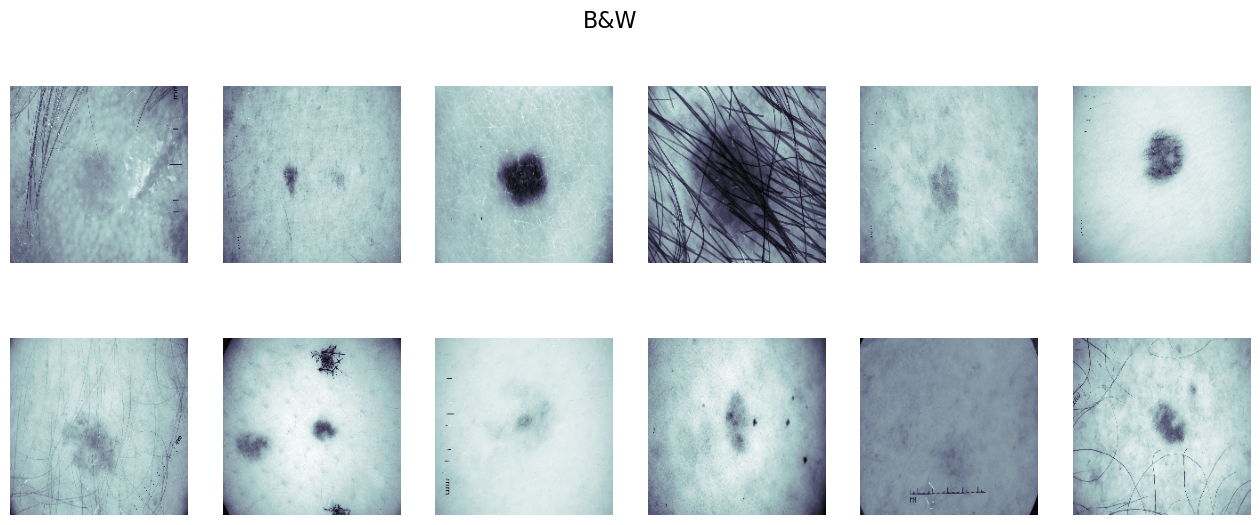

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle("B&W", fontsize = 16)

training_dicom_path = f'{base_path}train/'
jpeg_dicom_path = f'{base_path}jpeg/train/'

for i in range(0, 2*6):
    
    img_path = f'{jpeg_dicom_path}{train_df["image_name"][i]}.jpg'
    
    image = mpimg.imread(img_path)
    
    # Transform to B&W
    # The function converts an input image from one color space to another.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (200,200))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

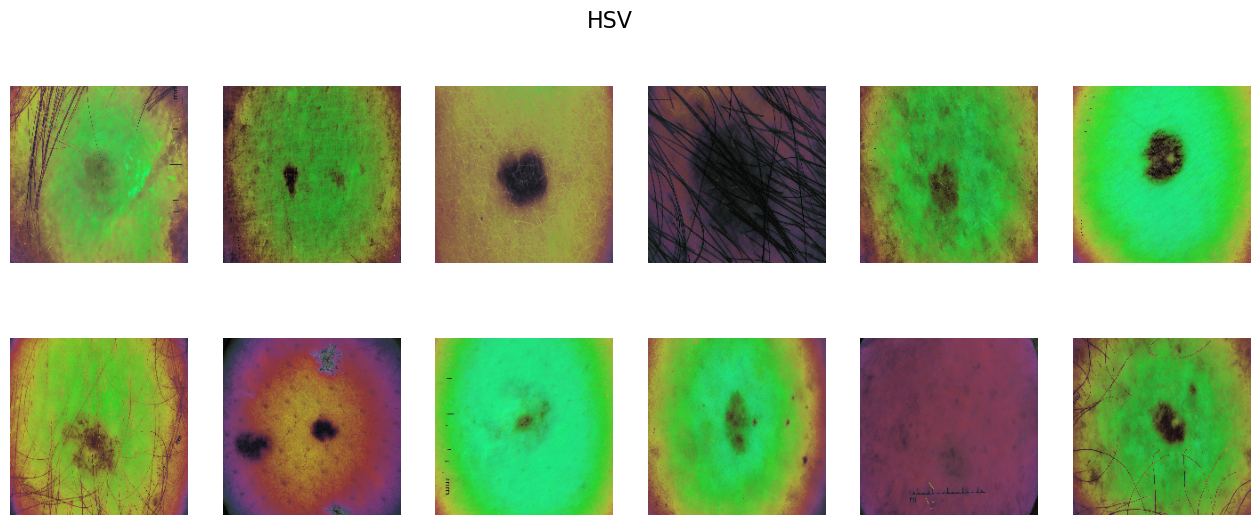

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle("HSV", fontsize = 16)

training_dicom_path = f'{base_path}train/'


for i in range(0, 2*6):
    
    img_path = f'{jpeg_dicom_path}{train_df["image_name"][i]}.jpg'
    
    image = mpimg.imread(img_path)
    
    # Transform to B&W
    # The function converts an input image from one color space to another.
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    image = cv2.resize(image, (200,200))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

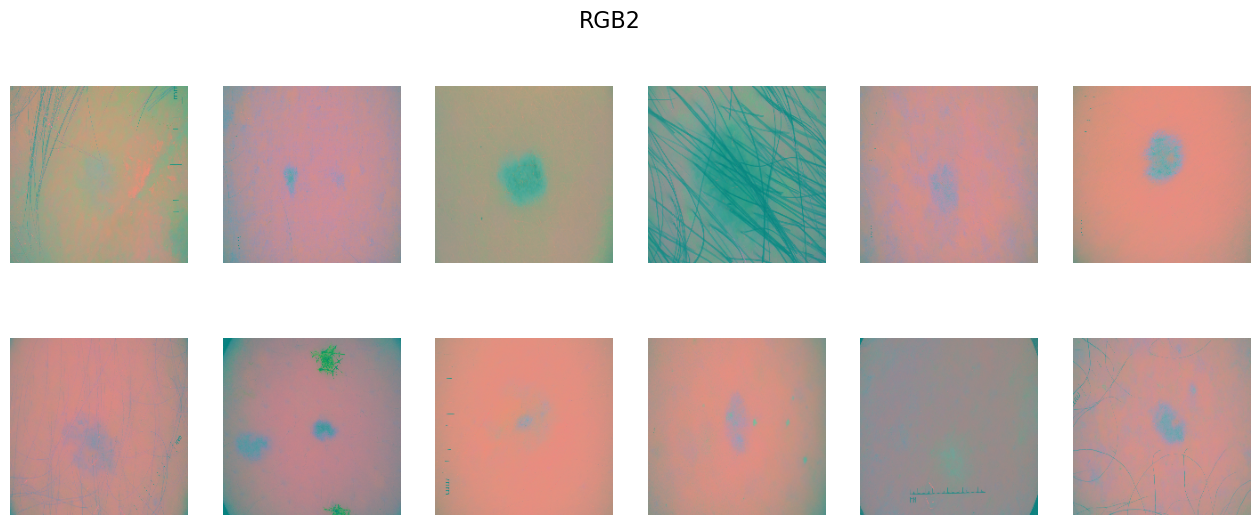

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle("RGB2", fontsize = 16)

training_dicom_path = f'{base_path}train/'


for i in range(0, 2*6):
    
    img_path = f'{jpeg_dicom_path}{train_df["image_name"][i]}.jpg'
    
    image = mpimg.imread(img_path)
    
    # Transform to B&W
    # The function converts an input image from one color space to another.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
    image = cv2.resize(image, (200,200))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

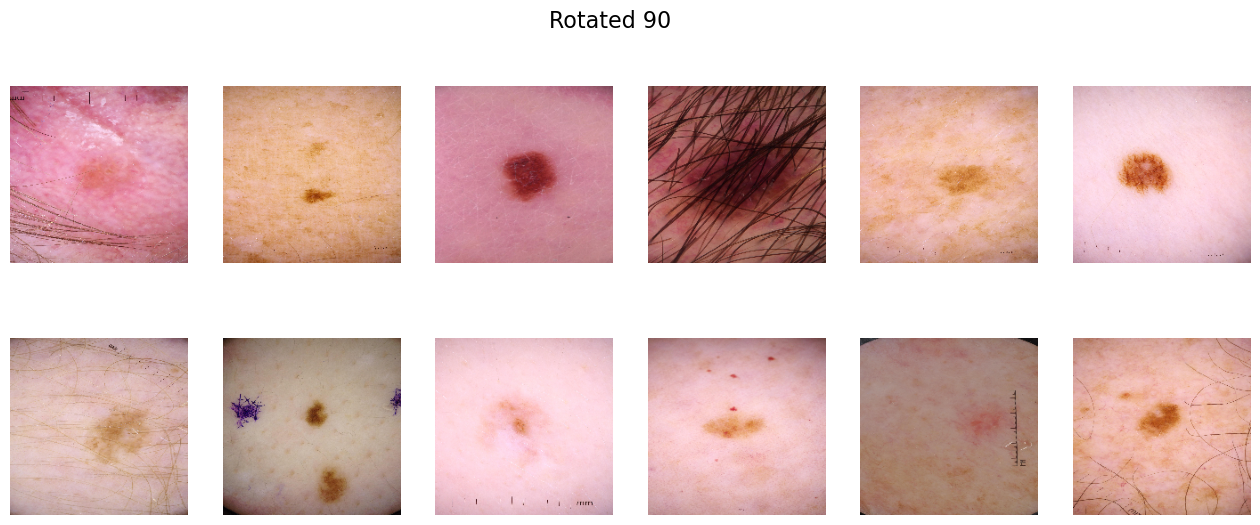

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle("Rotated 90", fontsize = 16)

training_dicom_path = f'{base_path}train/'


for i in range(0, 2*6):
    
    img_path = f'{jpeg_dicom_path}{train_df["image_name"][i]}.jpg'
    
    image = mpimg.imread(img_path)
    image = cv2.resize(image, (200,200))
    
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D((cX, cY), 90, 1.0)
    image = cv2.warpAffine(image, M, (w, h))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

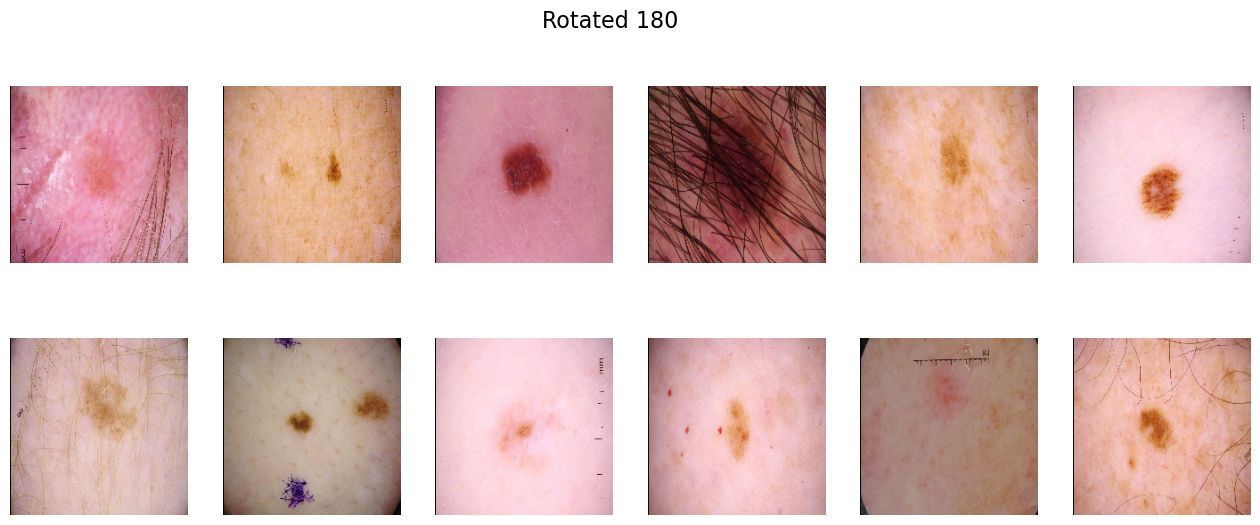

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle("Rotated 180", fontsize = 16)

training_dicom_path = f'{base_path}train/'


for i in range(0, 2*6):
    
    img_path = f'{jpeg_dicom_path}{train_df["image_name"][i]}.jpg'
    
    image = mpimg.imread(img_path)
    image = cv2.resize(image, (200,200))
    
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D((cX, cY), 180, 1.0)
    image = cv2.warpAffine(image, M, (w, h))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

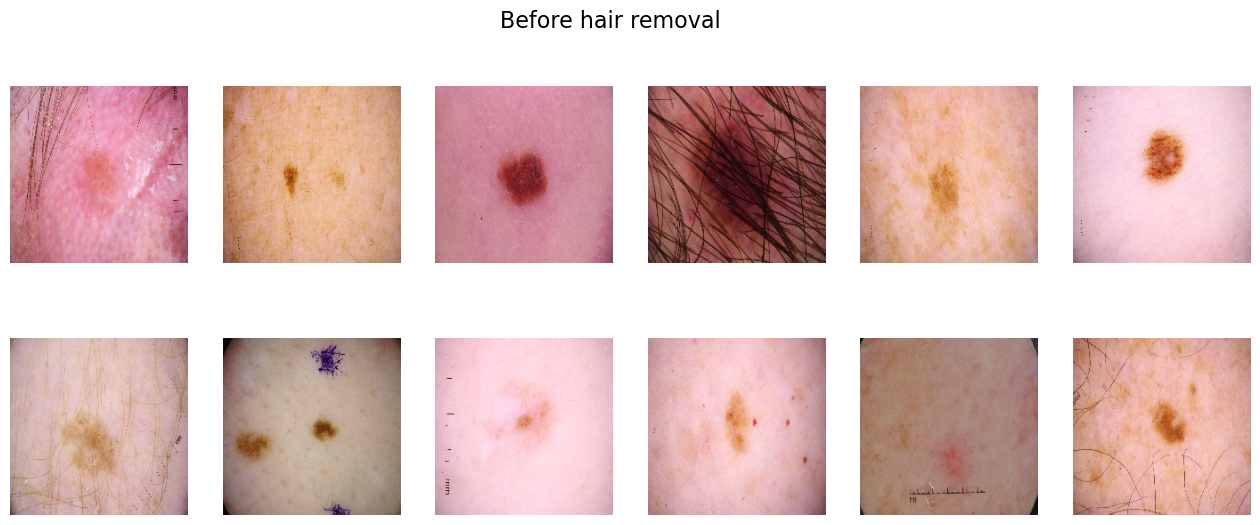

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle("Before hair removal", fontsize = 16)

training_dicom_path = f'{base_path}train/'
jpeg_dicom_path = f'{base_path}jpeg/train/'
kaggle_working = f'/kaggle/working/'

for i in range(0, 2*6):
    
    img_path = f'{jpeg_dicom_path}{train_df["image_name"][i]}.jpg'
    
    image = mpimg.imread(img_path)
   
    # Transform to B&W
    # The function converts an input image from one color space to another.

    image = cv2.resize(image, (200,200))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

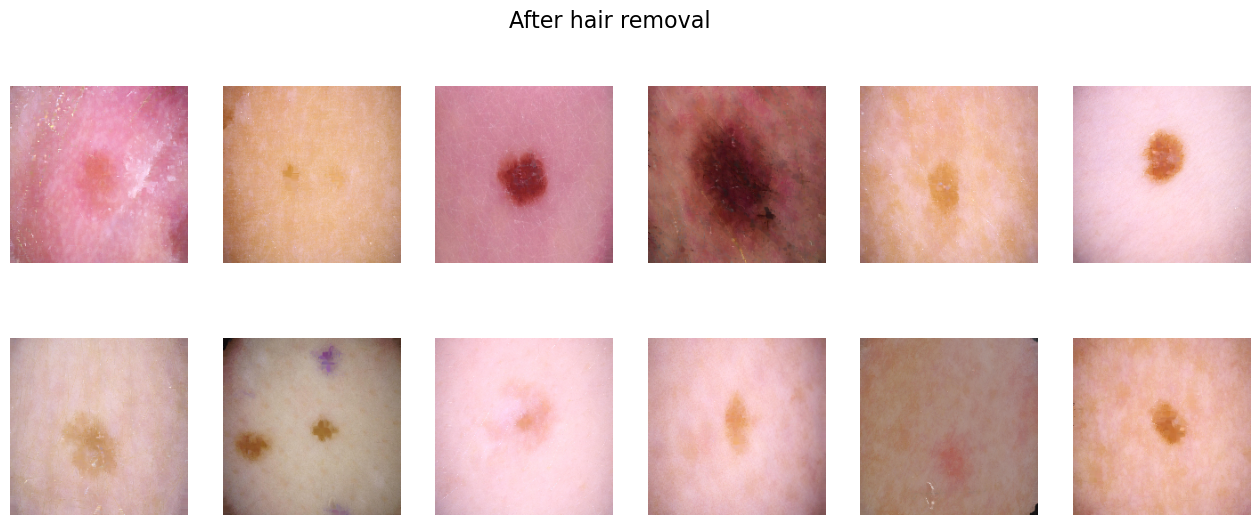

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle("After hair removal", fontsize = 16)

training_dicom_path = f'{base_path}train/'
jpeg_dicom_path = f'{base_path}jpeg/train/'
kaggle_working = f'/kaggle/working/'

for i in range(0, 2*6):
    
    img_path = f'{jpeg_dicom_path}{train_df["image_name"][i]}.jpg'
    
    image = mpimg.imread(img_path)
   
    # Transform to B&W
    # The function converts an input image from one color space to another.

    image = cv2.resize(image, (200,200))
    image = hair_remove(image)
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')
    

# Training

The training consists of using densenet-121 as well as an LGBM classifier to finally get the classifications for the test set. The densenet-121 model is retrained using the pictures and then is used to extract the features from them.

In [39]:
# Initialise the model to extract the features


img_size = 256
batch_size = 16 #16 images per batch

train_img_ids = train_df.image_name.values
n_batches = len(train_img_ids)//batch_size + 1

inp = Input((256,256,3))
backbone = DenseNet121(input_tensor=inp, include_top=False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Lambda(lambda x: K.expand_dims(x,axis=-1))(x)
x = AveragePooling1D(4)(x)
out = Lambda(lambda x: x[:,:,0])(x)

m = Model(inp,out)

29084464/29084464 [==============================] - 0s 0us/step


In [40]:
#Size to resize(256,256,3)
img_size = 256

#Paths to train and test images
train_img_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
test_img_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'
train_new_imgs = '/kaggle/working/additional_images/'

def resize_image(img):
    old_size = img.shape[:2]
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    img = cv2.resize(img, (new_size[1],new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0,0,0]
    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_img

def load_image(path, img_id):
    path = os.path.join(path,img_id+'.jpg')
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_img = resize_image(img)
    new_img = preprocess_input(new_img)
    return new_img

In [41]:
# Extract the features of the train dataset

features = {}

# Create progress bar
for b in tqdm_notebook(range(n_batches)):
    start = b*batch_size
    end = (b+1)*batch_size
    batch_ids = train_img_ids[start:end]
    batch_images = np.zeros((len(batch_ids),img_size,img_size,3))
    for i,img_id in enumerate(batch_ids):
        try:
            # Load and resize all images
            batch_images[i] = load_image(train_img_path,img_id)
        except:
            pass
    # Extract the features and add them to the dictionary
    batch_preds = m.predict(batch_images)
    for i,img_id in enumerate(batch_ids):
        features[img_id] = batch_preds[i]

  0%|          | 0/2071 [00:00<?, ?it/s]

1/1 [==============================] - 0s 377ms/step


In [42]:
# Create a dataframe and save the features as it takes a long time to extract
train_feats = pd.DataFrame.from_dict(features, orient='index')
train_feats.to_csv('train_img_features.csv')
train_feats.head()

0         1         2         3         4         5    \
ISIC_2637011  0.002475  0.679663  0.010111  0.018705  0.267253  0.002165   
ISIC_0015719  0.002824  0.271988  0.065081  0.028977  0.306713  0.002644   
ISIC_0052212  0.002857  0.540523  0.029826  0.015227  0.338847  0.002667   
ISIC_0068279  0.002257  0.539723  0.023596  0.020547  0.149721  0.002371   
ISIC_0074268  0.002553  0.317193  0.038689  0.024937  0.363818  0.002441   

                   6         7         8         9    ...       246       247  \
ISIC_2637011  0.011334  0.005727  0.104657  0.042771  ...  1.152694  0.613310   
ISIC_0015719  0.004327  0.003391  0.107767  0.035239  ...  0.722096  0.514084   
ISIC_0052212  0.007727  0.003463  0.161796  0.036068  ...  0.496952  0.257567   
ISIC_0068279  0.015601  0.003069  0.053026  0.040336  ...  1.107734  1.268810   
ISIC_0074268  0.004176  0.003809  0.112036  0.042411  ...  0.405280  0.168642   

                   248       249       250       251       252       253  \
ISIC_2637011  1.949774  0.334282  1.201511  0.610824  0.877143  1.799537   
ISIC_0015719  2.445422  0.263061  0.425468  0.349418  1.304480  1.265073   
ISIC_0052212  2.143370  1.048697  0.740639  1.578671  1.660438  1.411808   
ISIC_0068279  1.363725  0.025352  0.727919  0.056181  0.790206  1.616292   
ISIC_0074268  2.551557  0.293851  0.679758  0.460460  0.705966  1.555146   

                   254       255  
ISIC_2637011  1.069407  1.072875  
ISIC_0015719  0.388196  0.828559  
ISIC_0052212  0.982524  0.957257  
ISIC_0068279  0.892960  1.148712  
ISIC_0074268  0.696302  0.734603  

[5 rows x 256 columns]

In [43]:
test_img_ids = test_df.image_name.values
n_batches = len(test_img_ids)//batch_size + 1

In [44]:
# Extract the features from the test set

features = {}

# Create progress bar
for b in tqdm_notebook(range(n_batches)):
    start = b*batch_size
    end = (b+1)*batch_size
    batch_ids = test_img_ids[start:end]
    batch_images = np.zeros((len(batch_ids),img_size,img_size,3))
    for i,img_id in enumerate(batch_ids):
        try:
            # Load and resize all images
            batch_images[i] = load_image(test_img_path,img_id)
        except:
            pass
    # Extract the features and add them to the dictionary
    batch_preds = m.predict(batch_images)
    for i,img_id in enumerate(batch_ids):
        features[img_id] = batch_preds[i]

  0%|          | 0/687 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


In [45]:
# Create a dataframe and save the features as it takes a long time to extract
test_feats = pd.DataFrame.from_dict(features, orient='index')
test_feats.to_csv('test_img_features.csv')
test_feats.head()

0         1         2         3         4         5    \
ISIC_0052060  0.002105  0.305843  0.017969  0.019838  0.140682  0.002704   
ISIC_0052349  0.001862  0.346440  0.025026  0.019878  0.230535  0.002770   
ISIC_0058510  0.002032  0.346845  0.044869  0.028201  0.337340  0.002484   
ISIC_0073313  0.002308  0.522633  0.027931  0.023375  0.392308  0.002789   
ISIC_0073502  0.002763  0.143797  0.087915  0.029993  0.256645  0.002446   

                   6         7         8         9    ...       246       247  \
ISIC_0052060  0.006115  0.003355  0.053222  0.026019  ...  1.371735  0.342482   
ISIC_0052349  0.004312  0.004845  0.042162  0.036033  ...  1.199234  0.530462   
ISIC_0058510  0.004207  0.004467  0.107155  0.045127  ...  0.617997  0.298939   
ISIC_0073313  0.004190  0.003910  0.097859  0.041184  ...  0.389263  0.201505   
ISIC_0073502  0.003679  0.003070  0.107315  0.035580  ...  1.136608  0.251024   

                   248       249       250       251       252       253  \
ISIC_0052060  2.410012  1.332466  1.495224  0.813142  1.598752  1.458577   
ISIC_0052349  2.158940  0.352109  0.798527  0.757148  1.121776  1.141074   
ISIC_0058510  2.538396  0.490784  0.931718  0.900456  1.054487  1.235845   
ISIC_0073313  2.360847  0.434449  0.597937  0.679239  1.051381  1.649503   
ISIC_0073502  2.283633  1.094027  0.496460  0.819185  1.388227  2.653991   

                   254       255  
ISIC_0052060  0.471986  0.798401  
ISIC_0052349  0.966652  0.828317  
ISIC_0058510  0.982982  1.249841  
ISIC_0073313  0.395865  1.269377  
ISIC_0073502  0.334657  1.675066  

[5 rows x 256 columns]

In [46]:
train_feats = pd.read_csv('/kaggle/working/train_img_features.csv')
test_feats = pd.read_csv('/kaggle/working/test_img_features.csv')
train_feats.set_index(train_feats.columns[0],inplace=True)
test_feats.set_index(test_feats.columns[0],inplace=True)

In [47]:
# Merge the main dataframes with the training features on the image names

df_train_full = pd.merge(train_df, train_feats, how='inner', left_on='image_name', right_index=True)
df_test_full = pd.merge(test_df, test_feats, how='inner', left_on='image_name', right_index=True)

# Drop unnecessary columns
train = df_train_full.drop(['image_name','patient_id','diagnosis','benign_malignant', 'encoded_sex', 'encoded_anatomy', 'encoded_diagnosis'],axis=1)
test = df_test_full.drop(['image_name','patient_id', 'encoded_sex', 'encoded_anatomy'],axis=1)

# Encode the data
train.sex.fillna('NaN',inplace=True)
test.sex.fillna('NaN',inplace=True)
train.anatom_site_general_challenge.fillna('NaN',inplace=True)
test.anatom_site_general_challenge.fillna('NaN',inplace=True)
le_sex = LabelEncoder()
le_site = LabelEncoder()
train.sex = le_sex.fit_transform(train.sex)
test.sex = le_sex.transform(test.sex)
train.anatom_site_general_challenge = le_site.fit_transform(train.anatom_site_general_challenge)
test.anatom_site_general_challenge = le_site.transform(test.anatom_site_general_challenge)

In [109]:
# Use the Stratified K Fold method to split the data up and shuffle the images

folds = StratifiedKFold(n_splits= 10, shuffle=True)
oof_preds = np.zeros(train.shape[0])
sub_preds = np.zeros(test.shape[0])
feature_importance_df = pd.DataFrame()
features = [f for f in train.columns if f != 'target']

final_iterations = []
models = []

# Start the training process, iterating over each fold
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train[features], train['target'])):
    train_X, train_y = train[features].iloc[train_idx], train['target'].iloc[train_idx]
    valid_X, valid_y = train[features].iloc[valid_idx], train['target'].iloc[valid_idx]
    
    # Initialise the classifier
    clf = LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.001,
        max_depth=8,
        colsample_bytree=0.5,
        num_leaves=50,
        random_state=0
    )
    print('*****Fold: {}*****'.format(n_fold))
    
    # Start the fitting process
    clf.fit(train_X, train_y, eval_set=[(train_X, train_y), (valid_X, valid_y)], 
            eval_metric= 'auc', verbose= 20, categorical_feature=[0,2],early_stopping_rounds= 20)
    
    # Save the predictions
    oof_preds[valid_idx] = clf.predict_proba(valid_X, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test[features], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    best_iteration = clf.best_iteration_
    final_iterations.append(best_iteration)
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del clf, train_X, train_y, valid_X, valid_y
    gc.collect()

*****Fold: 0*****
[20]	training's auc: 0.941286	training's binary_logloss: 0.0858958	valid_1's auc: 0.863677	valid_1's binary_logloss: 0.0871663
Fold  1 AUC : 0.865446
*****Fold: 1*****
[20]	training's auc: 0.939763	training's binary_logloss: 0.0859761	valid_1's auc: 0.886053	valid_1's binary_logloss: 0.0871328
[40]	training's auc: 0.944166	training's binary_logloss: 0.0835525	valid_1's auc: 0.895002	valid_1's binary_logloss: 0.086142
[60]	training's auc: 0.94743	training's binary_logloss: 0.0814049	valid_1's auc: 0.901216	valid_1's binary_logloss: 0.0851595
[80]	training's auc: 0.950644	training's binary_logloss: 0.0794981	valid_1's auc: 0.907191	valid_1's binary_logloss: 0.0843505
[100]	training's auc: 0.951397	training's binary_logloss: 0.0777199	valid_1's auc: 0.910541	valid_1's binary_logloss: 0.0836418
[120]	training's auc: 0.954113	training's binary_logloss: 0.0760877	valid_1's auc: 0.912389	valid_1's binary_logloss: 0.0830188
[140]	training's auc: 0.955516	training's binary_log

In [49]:
final_predictions = pd.DataFrame({
    "image_name": test_df.image_name, 
    "target": sub_preds
})
final_predictions.to_csv('final_predictions.csv', index=False)